In [2]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *


In [3]:
DATA_DIR = "D:\Python Programs\Datasets\Imagenet\Imagenet_01"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
IMG_SHAPE = (64, 64)


In [4]:
def load_dataset_small(num_images_per_class_train=10, num_images_test=500):
    X_train = []
    X_test = []

    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)

    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    for img_name_i in test_imgs[0:num_images_test]:
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)
    return np.array(X_train), np.array(X_test)


In [5]:
X_train_orig, X_test_orig = load_dataset_small()

X_train = X_train_orig/255.
X_test = X_test_orig/255.


print("Number of training examples = " + str(X_train.shape[0]))
print("Number of test examples = " + str(X_test.shape[0]))
print("X_train shape: " + str(X_train.shape))


Number of training examples = 1990
Number of test examples = 500
X_train shape: (1990, 64, 64, 3)


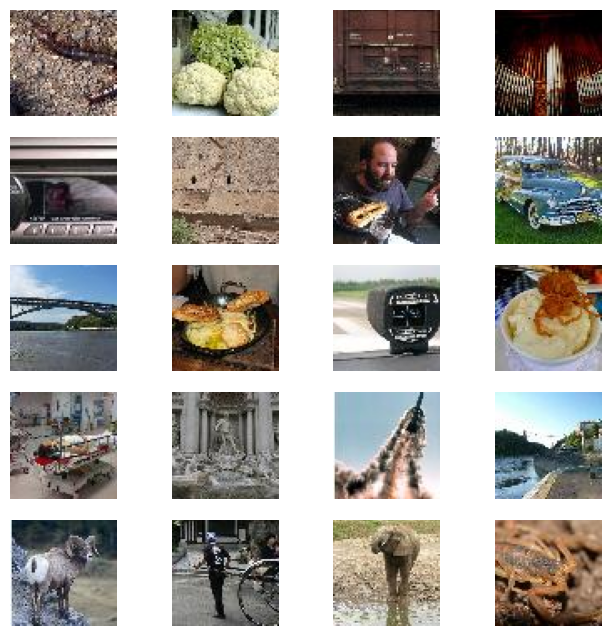

In [6]:
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows + 1):
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.imshow(X_train[img_idx])
plt.show()


In [7]:
input_S = X_train[0:X_train.shape[0] // 2]

input_C = X_train[X_train.shape[0] // 2:]


In [8]:
beta = 1.0


def rev_loss(s_true, s_pred):
    return beta * K.sum(K.square(s_true - s_pred))


def full_loss(y_true, y_pred):
    s_true, c_true = y_true[..., 0:3], y_true[..., 3:6]
    s_pred, c_pred = y_pred[..., 0:3], y_pred[..., 3:6]

    s_loss = rev_loss(s_true, s_pred)
    c_loss = K.sum(K.square(c_true - c_pred))
    return s_loss + c_loss


In [9]:
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C = Input(shape=(input_size))

    x3 = Conv2D(50, (3, 3), strides=(1, 1), padding='same',
                activation='relu', name='conv_prep0_3x3')(input_S)
    x4 = Conv2D(10, (4, 4), strides=(1, 1), padding='same',
                activation='relu', name='conv_prep0_4x4')(input_S)
    x5 = Conv2D(5, (5, 5), strides=(1, 1), padding='same',
                activation='relu', name='conv_prep0_5x5')(input_S)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides=(1, 1), padding='same',
                activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides=(1, 1), padding='same',
                activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides=(1, 1), padding='same',
                activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x = concatenate([input_C, x])

    x3 = Conv2D(50, (3, 3), strides=(1, 1), padding='same',
                activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides=(1, 1), padding='same',
                activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides=(1, 1), padding='same',
                activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides=(1, 1), padding='same',
                activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides=(1, 1), padding='same',
                activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides=(1, 1), padding='same',
                activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides=(1, 1), padding='same',
                activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides=(1, 1), padding='same',
                activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides=(1, 1), padding='same',
                activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides=(1, 1), padding='same',
                activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides=(1, 1), padding='same',
                activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides=(1, 1), padding='same',
                activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides=(1, 1), padding='same',
                activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides=(1, 1), padding='same',
                activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides=(1, 1), padding='same',
                activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])

    output_Cprime = Conv2D(3, (3, 3), strides=(
        1, 1), padding='same', activation='relu', name='output_C')(x)

    return Model(inputs=[input_S, input_C],
                 outputs=output_Cprime,
                 name='Encoder')


In [10]:
def make_decoder(input_size, fixed=False):

    # Reveal network
    reveal_input = Input(shape=(input_size))

    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input)

    x3 = Conv2D(50, (3, 3), strides=(1, 1), padding='same',
                activation='relu', name='conv_rev0_3x3')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides=(1, 1), padding='same',
                activation='relu', name='conv_rev0_4x4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides=(1, 1), padding='same',
                activation='relu', name='conv_rev0_5x5')(input_with_noise)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides=(1, 1), padding='same',
                activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides=(1, 1), padding='same',
                activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides=(1, 1), padding='same',
                activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides=(1, 1), padding='same',
                activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides=(1, 1), padding='same',
                activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides=(1, 1), padding='same',
                activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides=(1, 1), padding='same',
                activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides=(1, 1), padding='same',
                activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides=(1, 1), padding='same',
                activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides=(1, 1), padding='same',
                activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides=(1, 1), padding='same',
                activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides=(1, 1), padding='same',
                activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])

    output_Sprime = Conv2D(3, (3, 3), strides=(
        1, 1), padding='same', activation='tanh', name='output_S')(x)

    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name='Decoder')
    else:
        return Network(inputs=reveal_input,
                       outputs=output_Sprime,
                       name='DecoderFixed')


In [11]:
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C = Input(shape=(input_size))

    encoder = make_encoder(input_size)

    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False

    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)

    return encoder, decoder, autoencoder


In [12]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003


In [13]:
def train(e, lr=0.1):

  NB_EPOCHS = e
  BATCH_SIZE = 500

  encoder_model, reveal_model, autoencoder_model = make_model(
      input_S.shape[1:])

  K.set_value(autoencoder_model.optimizer.lr, lr)
  K.set_value(reveal_model.optimizer.lr, lr)
  m = input_S.shape[0]
  loss_history = []

  for epoch in range(NB_EPOCHS):

      np.random.shuffle(input_S)
      np.random.shuffle(input_C)
      t = tqdm(range(0, input_S.shape[0], BATCH_SIZE), mininterval=0)

      ae_loss = []
      rev_loss = []

      i = 0

      for idx in t:

          batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]

          C_prime = encoder_model.predict([batch_S, batch_C])
          aeLoss = autoencoder_model.train_on_batch(x=[batch_S, batch_C],
                                                    y=np.concatenate((batch_S, batch_C), axis=3))

          ae_loss.append(aeLoss)

          revLoss = reveal_model.train_on_batch(x=C_prime, y=batch_S)
          rev_loss.append(revLoss)

          i = idx
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f} | lr {}'.format(
              epoch + 1, i, m, np.mean(ae_loss), np.mean(rev_loss), lr))

      lr = lr_schedule(epoch + 1)
      mean_ae_loss = np.mean(ae_loss)
      loss_history.append(mean_ae_loss)

  autoencoder_model.save_weights('./model_weights.hdf5')
  autoencoder_model.save("model.h5")
  return loss_history, autoencoder_model


In [14]:
loss_history, autoencoder_model = train(1)


  0%|          | 0/2 [00:00<?, ?it/s]

16/16 [==============================] - 6s 383ms/step


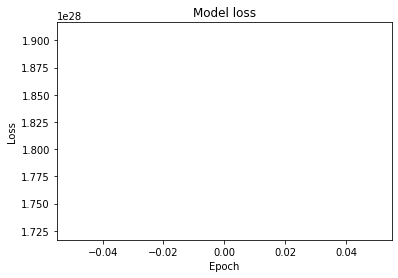

In [15]:
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [16]:
from keras.models import load_model


In [17]:
autoencoder_model.load_weights('/content/model_weights.hdf5')


OSError: Unable to open file (unable to open file: name = '/content/model_weights.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)